# Курсовой проект

## Подключение необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

%run functions.ipynb
%run classes4curs.ipynb

from IPython.display import HTML, display, Markdown
from tabulate import tabulate

import xgboost as xgb, lightgbm as lgbm, catboost as catb
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.simplefilter('ignore')

from matplotlib import pyplot as plt
%matplotlib inline

## Описание датасета

- __Home Ownership__ - домовладение
- __Annual Income__ - годовой доход
- __Years in current job__ - количество лет на текущем месте работы
- __Tax Liens__ - налоговые обременения
- __Number of Open Accounts__ - количество открытых счетов
- __Years of Credit History__ - количество лет кредитной истории
- __Maximum Open Credit__ - наибольший открытый кредит
- __Number of Credit Problems__ - количество проблем с кредитом
- __Months since last delinquent__ - количество месяцев с последней просрочки платежа
- __Bankruptcies__ - банкротства
- __Purpose__ - цель кредита
- __Term__ - срок кредита
- __Current Loan Amount__ - текущая сумма кредита
- __Current Credit Balance__ - текущий кредитный баланс
- __Monthly Debt__ - ежемесячный долг
- __Credit Default__ - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

## Глобальные значения

In [2]:
TEACHING_COLUMNS = ['Tax Liens',
                    'Number of Open Accounts',
                    'Years of Credit History',
                    'Maximum Open Credit',
                    'Number of Credit Problems',
                    'Current Loan Amount',
                    'Current Credit Balance',
                    'Monthly Debt']

TRAIN_DATASET = 'course_project_train.csv'
TEST_DATASET = 'course_project_test.csv'

RESULT_FILE = 'Putilin_predictions.csv'

## 1. Анализируем данные

__Необходимо проверить, чтобы данные в тренеровочной и тестовой выборке совпадали__

In [3]:
# загружаем данные тренеровочные
df_train = pd.read_csv(TRAIN_DATASET)
# выводим первые 10 строк
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [4]:
# смотрим размер данных
df_train.shape

(7500, 17)

In [5]:
# Смотрим какие данные где храняться
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [6]:
# загружаем данные тренеровочные
df_test = pd.read_csv(TEST_DATASET)
df_test.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
7,Rent,1215867.0,3 years,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,debt consolidation,Short Term,407726.0,120099.0,7599.0,701.0
8,Rent,NaN,5 years,0.0,8.0,9.1,370524.0,0.0,NaN,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
9,Home Mortgage,2140445.0,10+ years,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,debt consolidation,Short Term,391336.0,294500.0,18372.0,745.0


In [7]:
df_test.shape

(2500, 16)

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

##### Обзор целевой переменной

In [9]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

__Т.к. значение `1` намного меньше меньше чем `0`, то видно нарушение пропорции.__

##### Обзор количественных признаков

In [10]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [11]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


##### Обзор номинативных признаков

In [12]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(f"Feature name: {color.BOLD}{cat_colname}{color.END}\n\n{df_train[cat_colname].value_counts()}\n{'*' * 100}\n")

Feature name: Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Feature name: Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Feature name: Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    

## 2. Корректируем данные, под более реальные

In [13]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [14]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

__Так как "Years in current job" и "Bankruptcies" не так много пустых, то просто используем mode__

In [15]:
for field in ['Bankruptcies', 'Years in current job']:
    df_train.loc[df_train[field].isnull(), field] = df_train[field].mode()[0]
    df_test.loc[df_test[field].isnull(), field] = df_test[field].mode()[0]
    print(f"Fields name: {color.BOLD}{field}{color.END}\n\n{df_train[field].value_counts()}\n")    

Fields name: Bankruptcies

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

Fields name: Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64



__Так как "Months since last delinquent", "Annual Income", "Credit Score" довольно таки много пустых значений, лучше использовать регрессор и заполнить пустые значения используя его__

In [16]:
for field in ['Months since last delinquent', 'Annual Income', 'Credit Score']:
    model_regressor = build_regressor(df_train, TEACHING_COLUMNS, field)
    df_train.loc[df_train[field].isnull(), field] = predict_regressor(df_train, model_regressor, TEACHING_COLUMNS, field)
    df_test.loc[df_test[field].isnull(), field] = predict_regressor(df_test, model_regressor, TEACHING_COLUMNS, field)
    print(f"Fields name: {color.BOLD}{field}{color.END}\n\n{df_train[field].value_counts()}\n")    

Fields name: Months since last delinquent

14.000000    76
29.000000    71
33.000000    68
8.000000     68
12.000000    65
             ..
35.112354     1
31.154724     1
40.923843     1
33.909013     1
34.563905     1
Name: Months since last delinquent, Length: 4170, dtype: int64

Fields name: Annual Income

1.161660e+06    4
9.694750e+05    4
1.043651e+06    4
1.058376e+06    4
1.338113e+06    4
               ..
1.102722e+06    1
1.299334e+06    1
6.902320e+05    1
2.944300e+06    1
1.179653e+06    1
Name: Annual Income, Length: 7035, dtype: int64

Fields name: Credit Score

740.000000     169
747.000000     168
748.000000     157
745.000000     152
742.000000     151
              ... 
1231.559422      1
589.000000       1
1260.530042      1
1212.288533      1
1206.864595      1
Name: Credit Score, Length: 1825, dtype: int64



__Значение `Credit Score` было взято из интернето, потому значения более 850, могут являться не правильными (ошибочными), такие значения разделим на 10__

In [17]:
df_train.loc[df_train['Credit Score'] > 850, 'Credit Score'] = df_train['Credit Score'].div(10)
df_test.loc[df_test['Credit Score'] > 850, 'Credit Score'] = df_test['Credit Score'].div(10)

__Смотрим, еслть ли еще данные не скорректированные__

In [18]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [19]:
len(df_test) - df_test.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

### 3. Обработка выбросов

In [20]:
clear_outlier_all(df_train, df_train.select_dtypes(include='float64').columns, TEACHING_COLUMNS)

"Annual Income"
Общая доля выбросов в процентах 4.83%

"Number of Open Accounts"
Общая доля выбросов в процентах 2.27%

"Years of Credit History"
Общая доля выбросов в процентах 3.04%

"Maximum Open Credit"
Общая доля выбросов в процентах 6.21%

"Months since last delinquent"
Общая доля выбросов в процентах 28.21%

"Current Loan Amount"
Общая доля выбросов в процентах 11.6%

"Current Credit Balance"
Общая доля выбросов в процентах 5.87%

"Monthly Debt"
Общая доля выбросов в процентах 3.4%

"Credit Score"
Общая доля выбросов в процентах 20.75%



In [21]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.228795e+06,0.030133,10.719067,17.576560,9.451537e+05,0.170000,34.554229,0.116933,1.187318e+07,2.898332e+05,16399.185067,719.751714,0.281733
std,4.964818e+05,0.271604,4.228931,5.940664,1.602622e+07,0.498598,3.902648,0.346904,3.192612e+07,3.178714e+05,9748.500526,25.101717,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,19.678192,0.000000,1.124200e+04,0.000000e+00,0.000000,582.894684,0.000000
25%,8.749548e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,33.063133,0.000000,1.801690e+05,1.142565e+05,9243.250000,713.203107,0.000000
50%,1.135944e+06,0.000000,10.000000,16.600000,4.781590e+05,0.000000,34.112369,0.000000,3.095730e+05,2.093230e+05,15203.500000,722.000000,0.000000
75%,1.520342e+06,0.000000,13.000000,21.000000,7.935015e+05,0.000000,35.182921,0.000000,5.198820e+05,3.604062e+05,22416.250000,738.000000,1.000000
max,2.747964e+06,7.000000,23.000000,34.200000,1.304726e+09,7.000000,57.415124,4.000000,1.000000e+08,6.506797e+06,44382.000000,922.044700,1.000000


In [22]:
clear_outlier_all(df_test, df_test.select_dtypes(include='float64').columns, TEACHING_COLUMNS)

"Annual Income"
Общая доля выбросов в процентах 4.68%

"Number of Open Accounts"
Общая доля выбросов в процентах 1.84%

"Years of Credit History"
Общая доля выбросов в процентах 2.8%

"Maximum Open Credit"
Общая доля выбросов в процентах 6.24%

"Months since last delinquent"
Общая доля выбросов в процентах 29.72%

"Current Loan Amount"
Общая доля выбросов в процентах 11.88%

"Current Credit Balance"
Общая доля выбросов в процентах 5.0%

"Monthly Debt"
Общая доля выбросов в процентах 2.76%

"Credit Score"
Общая доля выбросов в процентах 20.52%



In [23]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2.500000e+03,2500.000000,2500.000000,2500.00000,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000
mean,1.228468e+06,0.035200,10.840400,17.64496,7.105704e+05,0.162000,34.153688,0.106800,1.215572e+07,225623.373600,17378.355600,719.158320
std,4.847014e+05,0.386291,4.263496,6.14067,1.511983e+06,0.559894,3.755741,0.356994,3.226097e+07,173711.173699,9469.676384,24.779001
min,1.065330e+05,0.000000,1.000000,3.90000,0.000000e+00,0.000000,22.000000,0.000000,1.542200e+04,0.000000,93.000000,585.000000
25%,8.919205e+05,0.000000,8.000000,13.40000,2.785860e+05,0.000000,32.938777,0.000000,1.871265e+05,92867.250000,10024.750000,712.000000
50%,1.149063e+06,0.000000,10.000000,16.60000,4.786760e+05,0.000000,33.974332,0.000000,3.223660e+05,188033.500000,16642.500000,721.242907
75%,1.529417e+06,0.000000,13.000000,21.40000,8.025985e+05,0.000000,35.008750,0.000000,5.225825e+05,323460.750000,24146.000000,738.000000
max,2.694257e+06,15.000000,23.000000,35.00000,5.448439e+07,15.000000,50.374897,5.000000,1.000000e+08,747992.000000,44898.000000,751.000000


### 4. Построение новых признаков

##### Id

In [24]:
df_train.insert(0, 'ID', df_train.index.tolist())

In [25]:
df_test.insert(0, 'ID', df_test.index.tolist())

##### Term

In [26]:
df_train['Is_Term'] = df_train['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [27]:
df_test['Is_Term'] = df_test['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

##### Years in current job

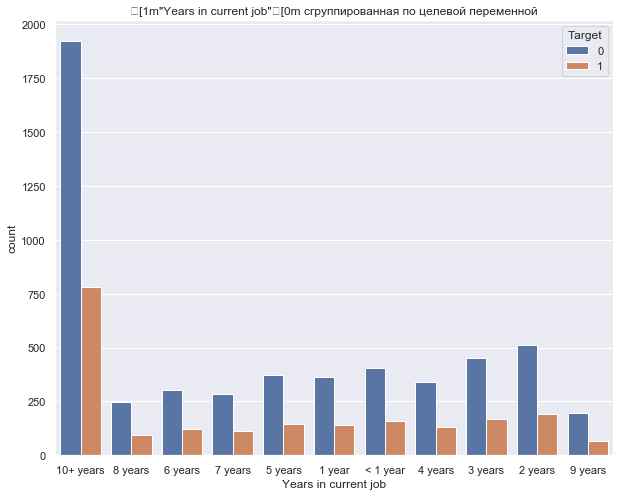

In [28]:
grouped_by_target(df_train, 'Years in current job', 'Credit Default')

In [29]:
df_train['Is_Years_in_current_job'] = df_train['Years in current job'].map({'< 1 year': '0',
                                                                            '1 year': '1',
                                                                            '2 years': '2',
                                                                            '3 years': '3',
                                                                            '4 years': '4',
                                                                            '5 years': '5',
                                                                            '6 years': '6',
                                                                            '7 years': '7',
                                                                            '8 years': '8',
                                                                            '9 years': '9',
                                                                            '10+ years': '10'}).astype(int)

In [30]:
df_test['Is_Years_in_current_job'] = df_test['Years in current job'].map({'Unknown': '-1',
                                                                            '< 1 year': '0',
                                                                            '1 year': '1',
                                                                            '2 years': '2',
                                                                            '3 years': '3',
                                                                            '4 years': '4',
                                                                            '5 years': '5',
                                                                            '6 years': '6',
                                                                            '7 years': '7',
                                                                            '8 years': '8',
                                                                            '9 years': '9',
                                                                            '10+ years': '10'}).astype(int)

##### Home Ownership

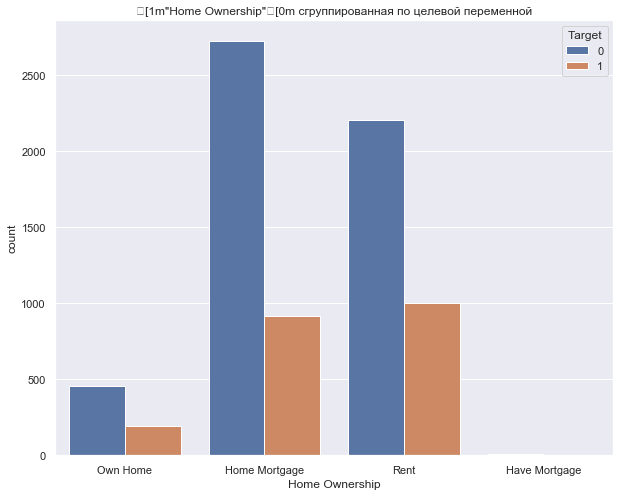

In [31]:
grouped_by_target(df_train, 'Home Ownership', 'Credit Default')

In [32]:
combine_into_category_table(df_train, 'Home Ownership', 'Credit Default', 'ID')

,Own Home,Home Mortgage,Rent,Have Mortgage
Own Home,,False,True,True
Home Mortgage,False,,False,True
Rent,True,False,,True
Have Mortgage,True,True,True,


In [33]:
df_train['Is_Home_Ownership'] = df_train['Home Ownership'].map({'Own Home':'0', 
                                                                'Rent':'0', 
                                                                'Have Mortgage':'0', 
                                                                'Home Mortgage':'1'}).astype(int)

In [34]:
df_test['Is_Home_Ownership'] = df_test['Home Ownership'].map({'Own Home':'0', 
                                                                'Rent':'0', 
                                                                'Have Mortgage':'0', 
                                                                'Home Mortgage':'1'}).astype(int)

##### Purpose

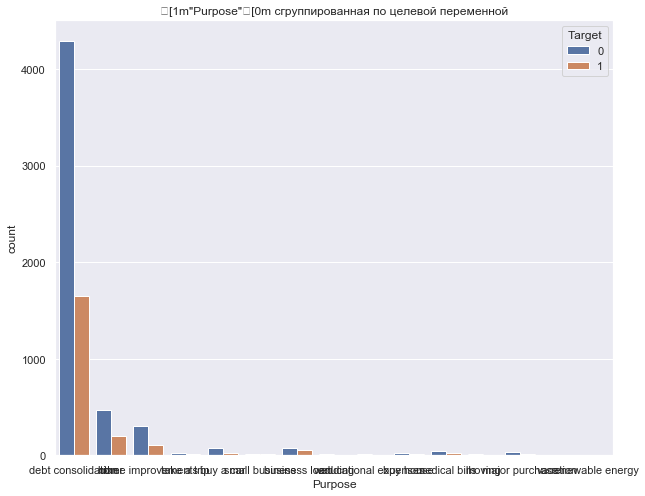

In [35]:
grouped_by_target(df_train, 'Purpose', 'Credit Default')

In [36]:
combine_into_category_table(df_train, 'Purpose', 'Credit Default', 'ID')

,debt consolidation,other,home improvements,take a trip,buy a car,small business,business loan,wedding,educational expenses,buy house,medical bills,moving,major purchase,vacation,renewable energy
debt consolidation,,True,True,True,True,False,False,True,True,True,True,True,True,True,False
other,True,,True,True,True,False,False,True,True,True,True,True,True,True,False
home improvements,True,True,,True,True,False,False,True,True,True,True,True,True,True,False
take a trip,True,True,True,,True,False,True,True,True,True,True,True,True,True,False
buy a car,True,True,True,True,,False,False,True,True,True,True,True,True,True,False
small business,False,False,False,False,False,,True,True,False,False,False,False,False,True,False
business loan,False,False,False,True,False,True,,True,False,True,True,True,False,True,False
wedding,True,True,True,True,True,True,True,,True,True,True,True,True,True,False
educational expenses,True,True,True,True,True,False,False,True,,True,True,True,True,True,False
buy house,True,True,True,True,True,False,True,True,True,,True,True,True,True,False


Очевидно, что все значения показателя, кроме "small business", "business loan" и "renewable energy" можно собрать в одно значение.

In [37]:
df_train['Is_Purpose'] = df_train['Purpose'].map({'debt consolidation':'other',
                                                  'other':'other',
                                                  'home improvements':'other',
                                                  'take a trip':'other',
                                                  'buy a car':'other',
                                                  'small business':'small business',
                                                  'business loan':'business loan',
                                                  'wedding':'other',
                                                  'educational expenses':'other',
                                                  'buy house':'other',
                                                  'medical bills':'other',
                                                  'moving':'other',
                                                  'major purchase':'other',
                                                  'vacation':'other',
                                                  'renewable energy':'renewable energy'})

In [38]:
df_test['Is_Purpose'] = df_test['Purpose'].map({'debt consolidation':'other',
                                                'other':'other',
                                                'home improvements':'other',
                                                'take a trip':'other',
                                                'buy a car':'other',
                                                'small business':'small business',
                                                'business loan':'business loan',
                                                'wedding':'other',
                                                'educational expenses':'other',
                                                'buy house':'other',
                                                'medical bills':'other',
                                                'moving':'other',
                                                'major purchase':'other',
                                                'vacation':'other',
                                                'renewable energy':'renewable energy'})

In [39]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Is_Purpose'], prefix='Is_Purpose')], axis=1)

In [40]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['Is_Purpose'], prefix='Is_Purpose')], axis=1)

### 5. Анализ данных полученных данных

#### Выделение целевой переменной и групп признаков

In [41]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns[1:17].to_list()
NEW_FEATURE_NAMES = df_train.columns.drop(df_train.columns[1:-8])

In [42]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

##### Обзор распределения

In [43]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

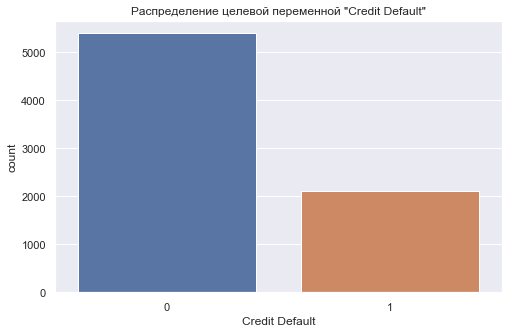

In [44]:
# пропорция все же нарушена
plt.figure(figsize=(8, 5))
sns.countplot(x=TARGET_NAME, data=df_train)
plt.title(f'Распределение целевой переменной "{TARGET_NAME}"')
plt.show()

##### Корреляция с базовыми признаками

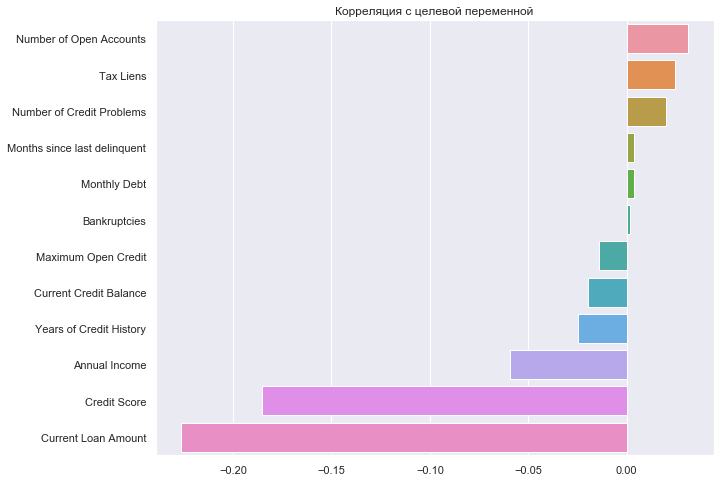

In [45]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Корреляция с целевой переменной')
plt.show()

Следующие показатели возможно имеет смысл сделать категориальными (у них мало классов):
- Tax Liens
- Number of Credit Problems
- Bankruptcies

__Оценка признака «Annual Income» в разрезе целевой переменной__

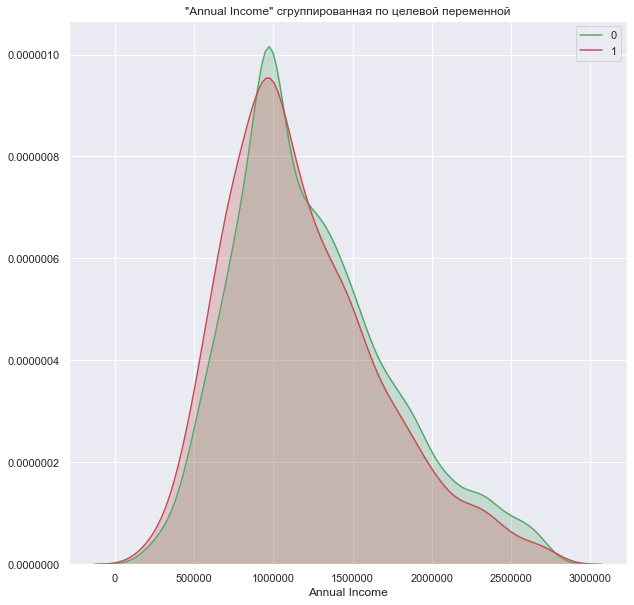

Показатель «Annual Income» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


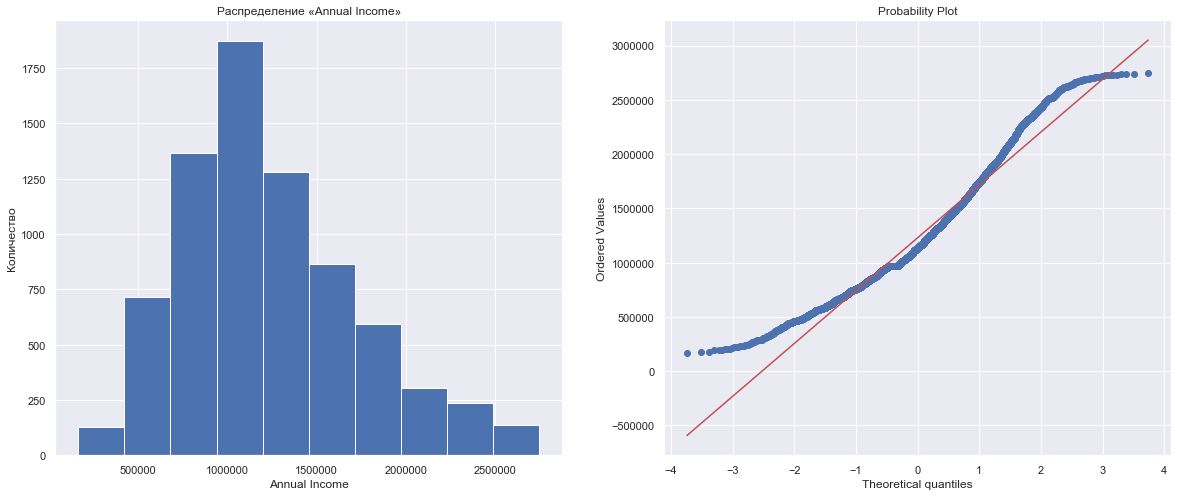

По показателю «Annual Income» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


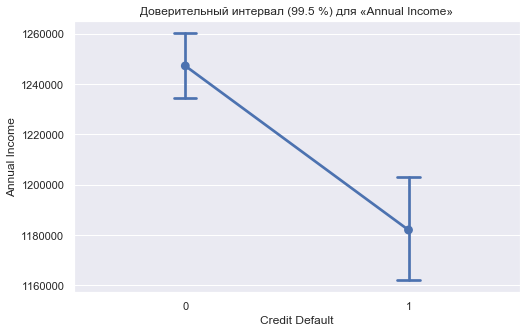

__Оценка признака «Tax Liens» в разрезе целевой переменной__

Показатель «Tax Liens» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


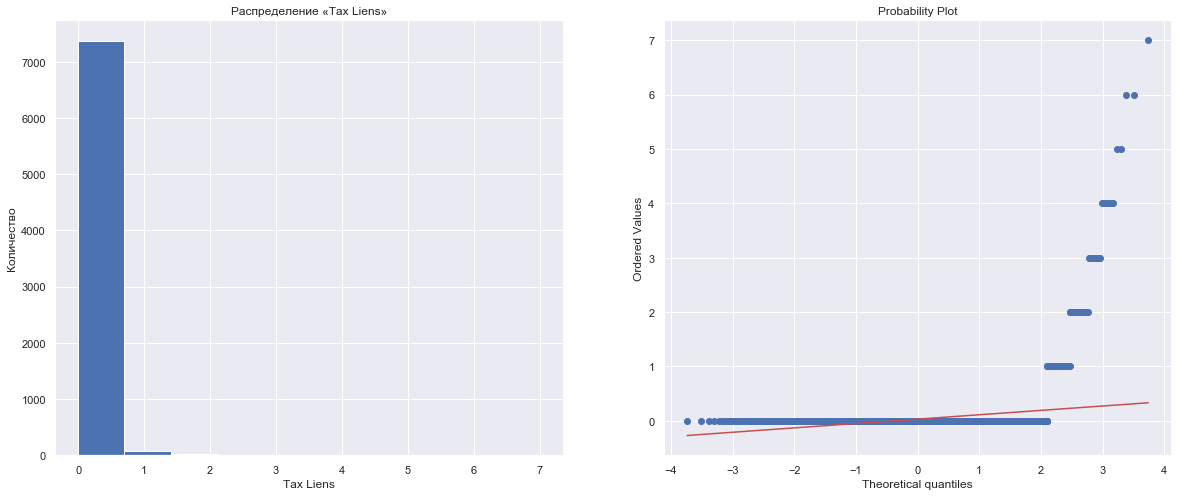

По показателю «Tax Liens» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


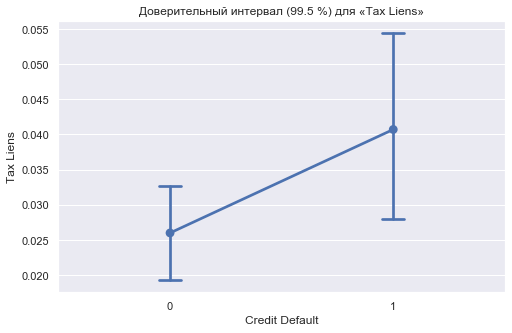

__Оценка признака «Number of Open Accounts» в разрезе целевой переменной__

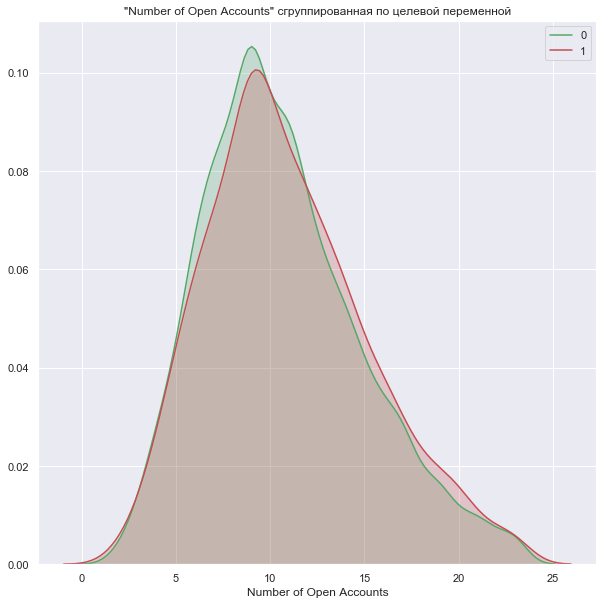

Показатель «Number of Open Accounts» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


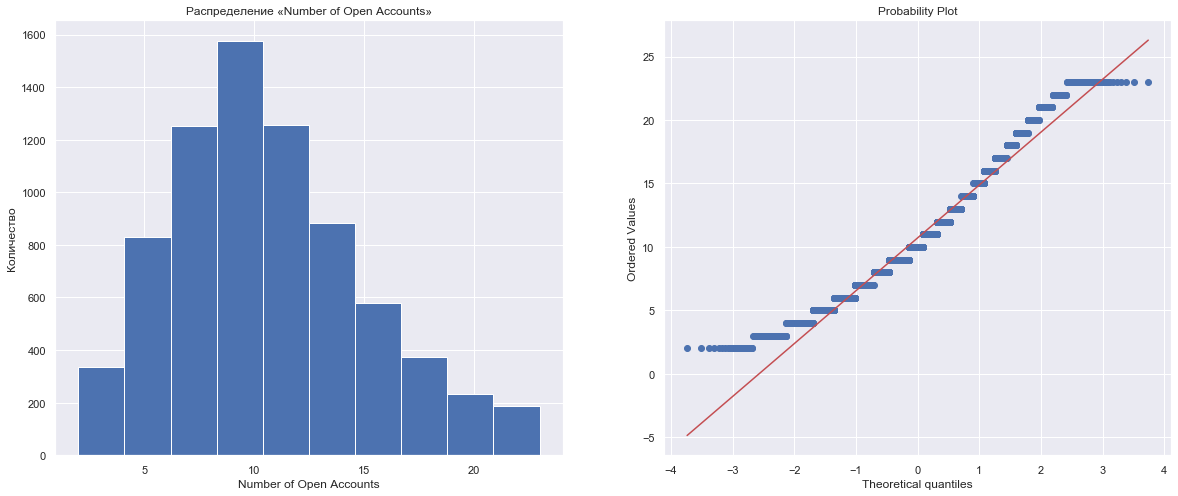

По показателю «Number of Open Accounts» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


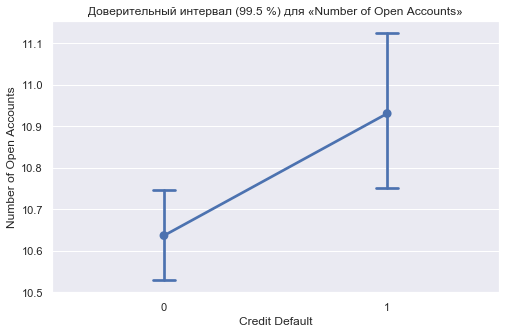

__Оценка признака «Years of Credit History» в разрезе целевой переменной__

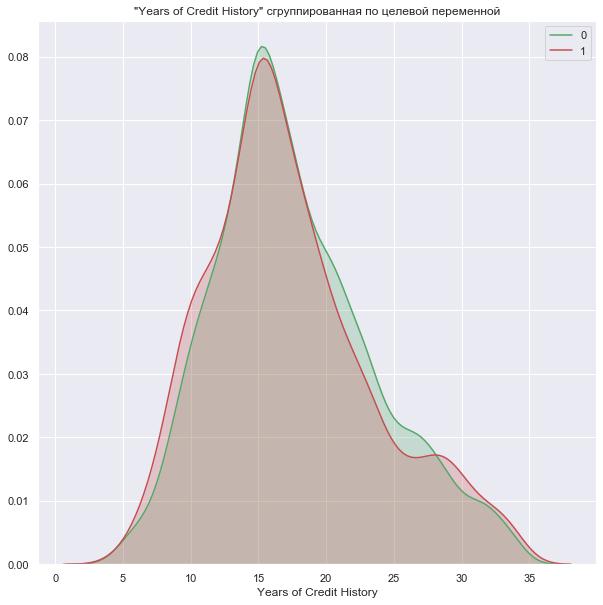

Показатель «Years of Credit History» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


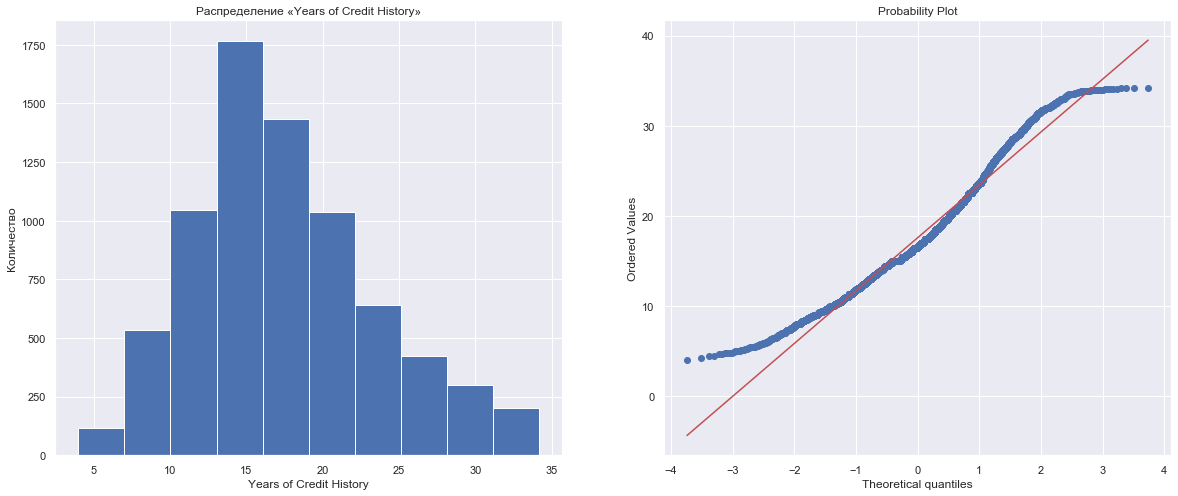

По показателю «Years of Credit History» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


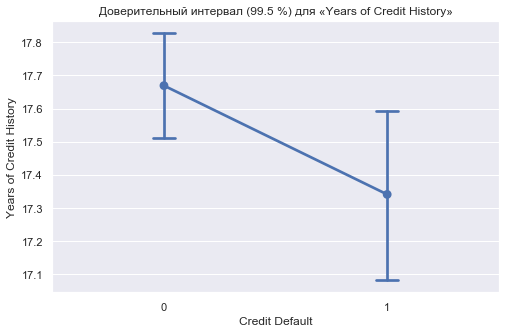

__Оценка признака «Maximum Open Credit» в разрезе целевой переменной__

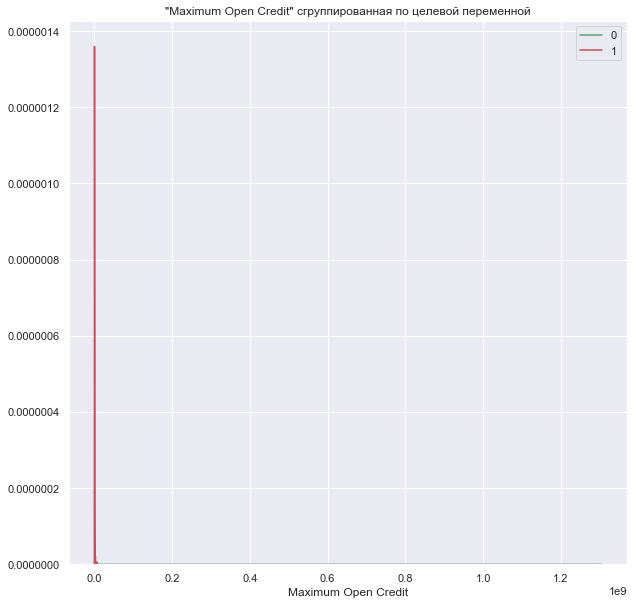

Показатель «Maximum Open Credit» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


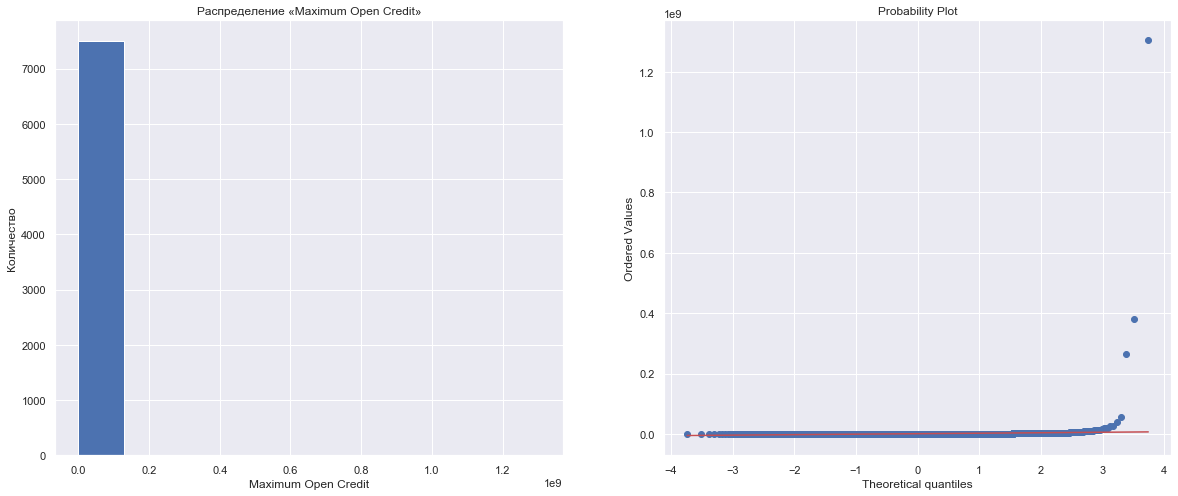

По показателю «Maximum Open Credit» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


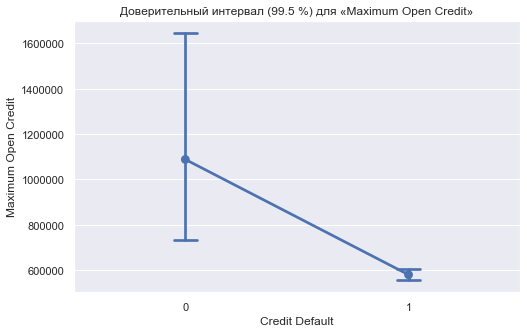

__Оценка признака «Number of Credit Problems» в разрезе целевой переменной__

Показатель «Number of Credit Problems» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


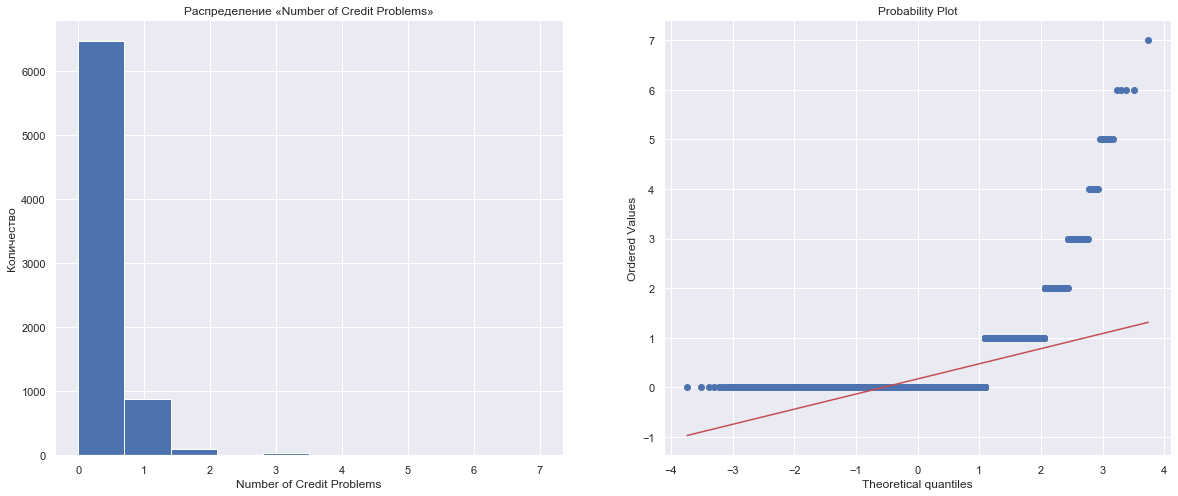

По показателю «Number of Credit Problems» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


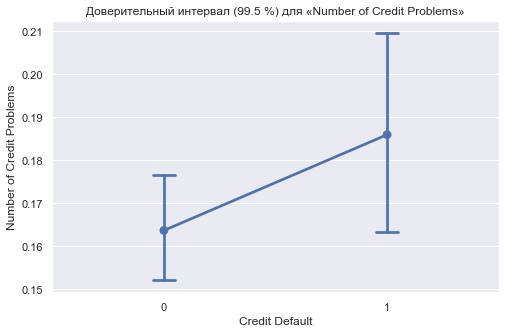

__Оценка признака «Months since last delinquent» в разрезе целевой переменной__

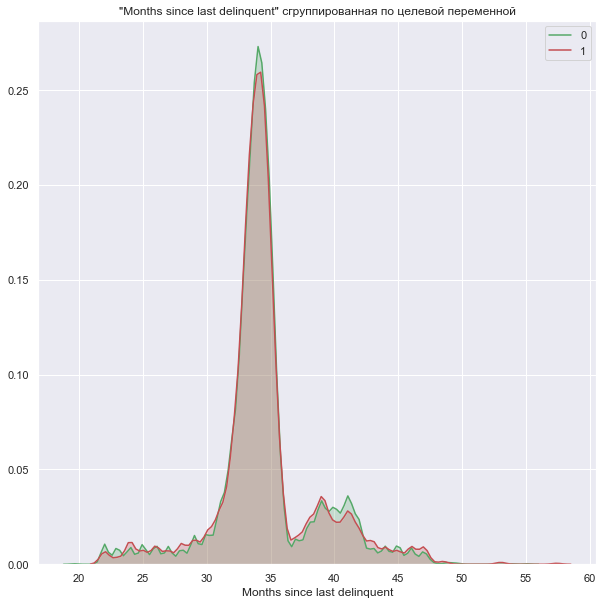

Показатель «Months since last delinquent» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


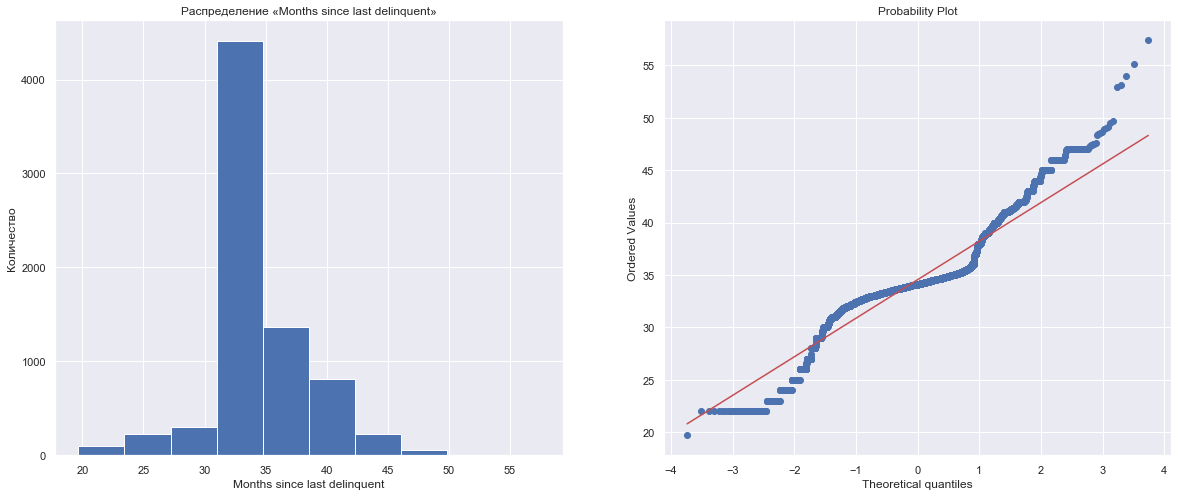

По показателю «Months since last delinquent» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


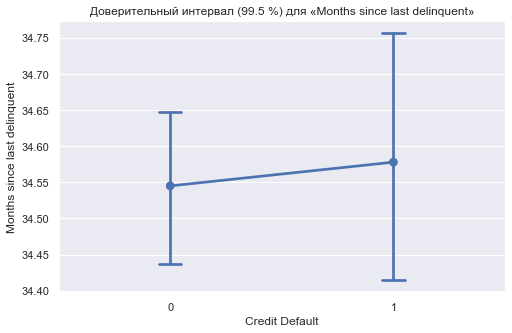

__Оценка признака «Bankruptcies» в разрезе целевой переменной__

Показатель «Bankruptcies» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


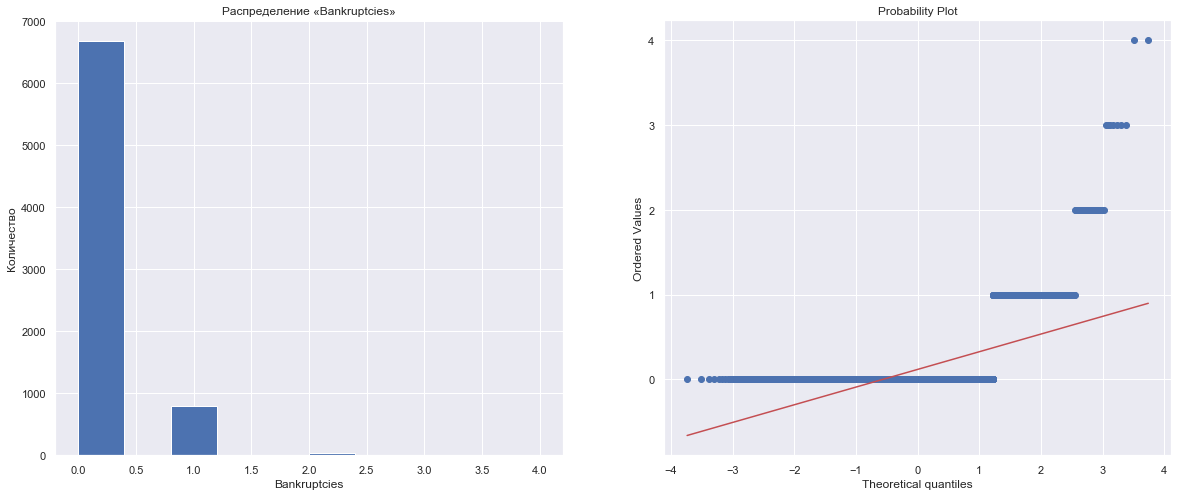

По показателю «Bankruptcies» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


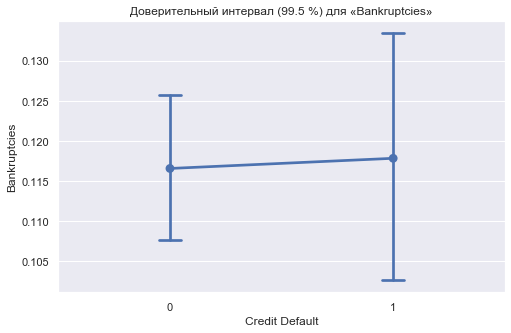

__Оценка признака «Current Loan Amount» в разрезе целевой переменной__

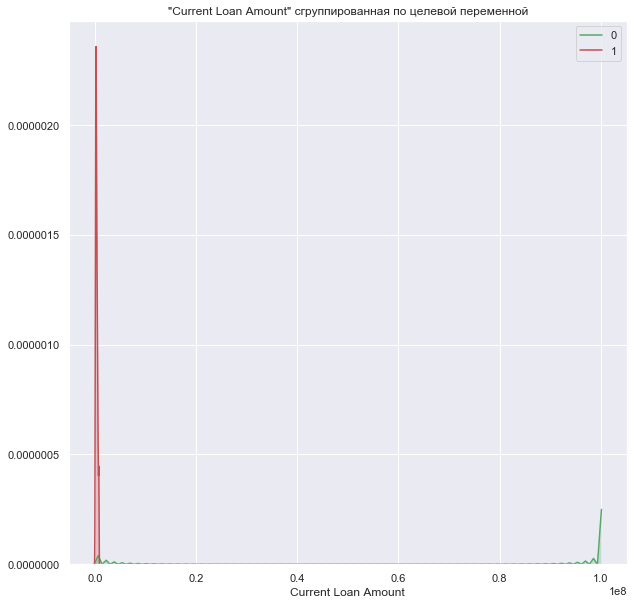

Показатель «Current Loan Amount» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


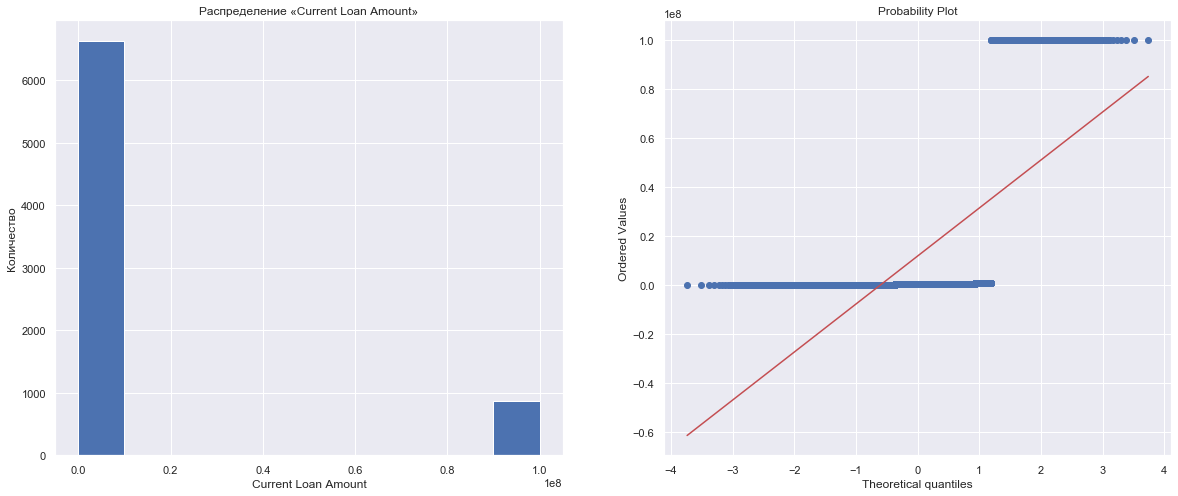

По показателю «Current Loan Amount» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


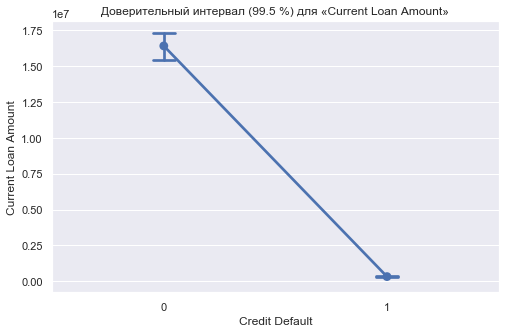

__Оценка признака «Current Credit Balance» в разрезе целевой переменной__

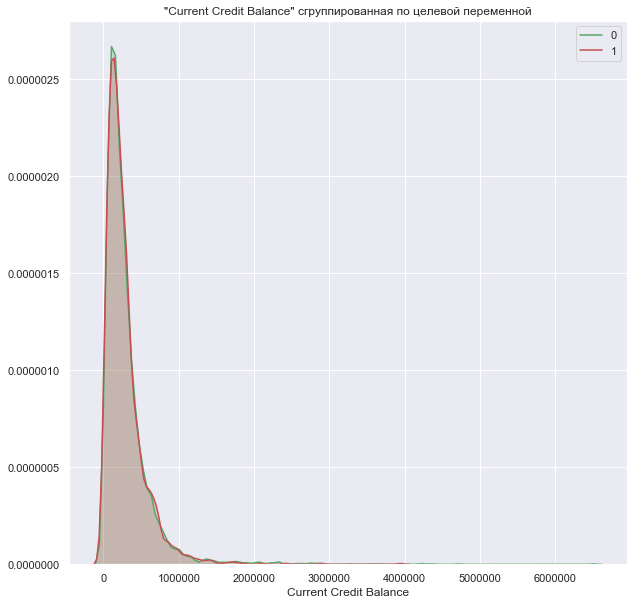

Показатель «Current Credit Balance» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


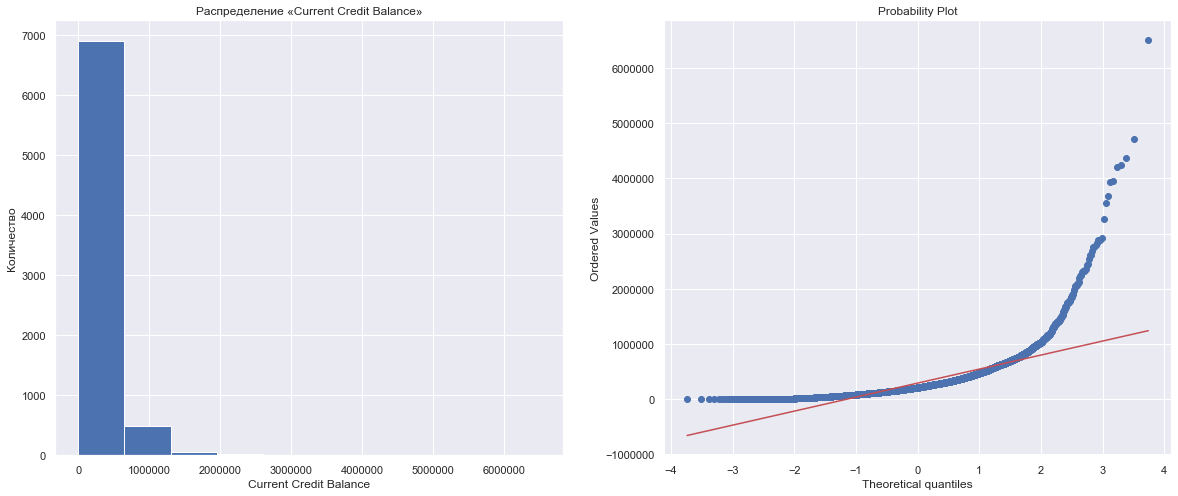

По показателю «Current Credit Balance» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


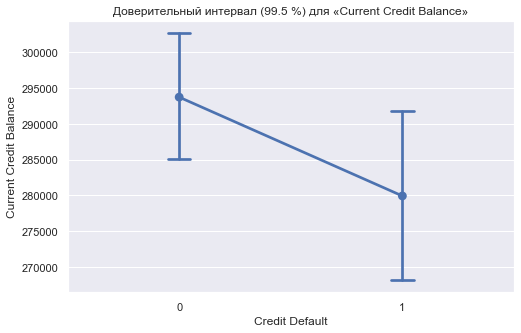

__Оценка признака «Monthly Debt» в разрезе целевой переменной__

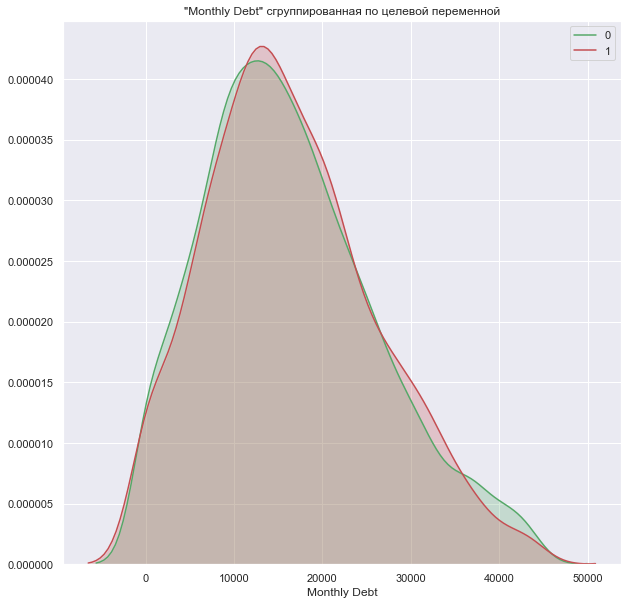

Показатель «Monthly Debt» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


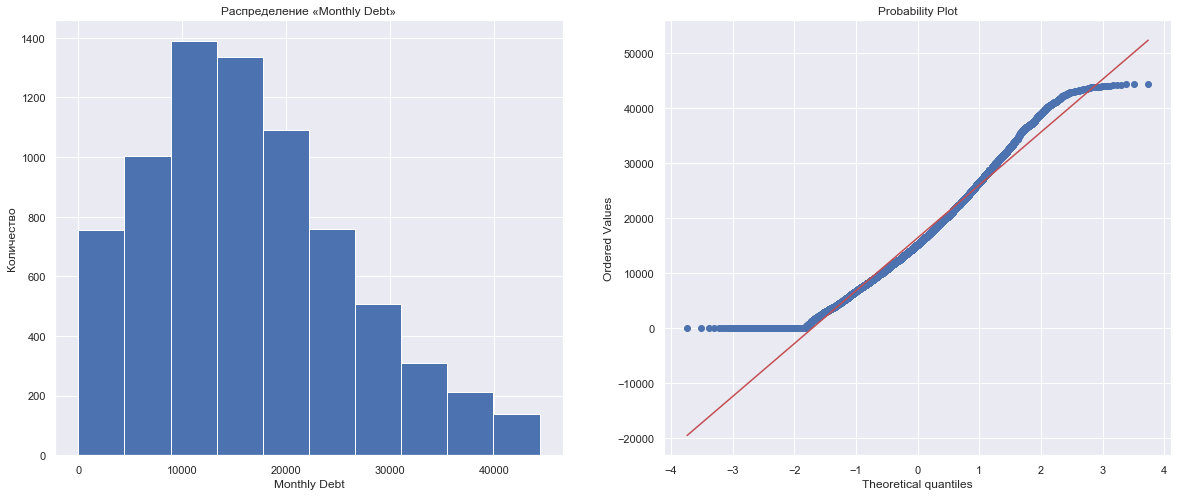

По показателю «Monthly Debt» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


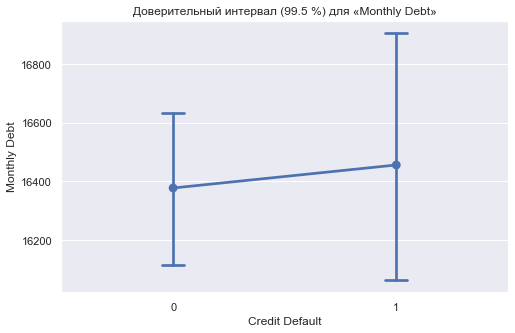

__Оценка признака «Credit Score» в разрезе целевой переменной__

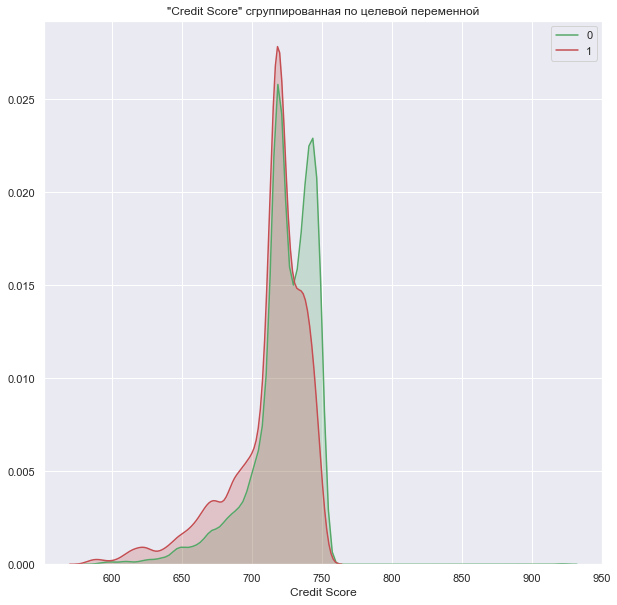

Показатель «Credit Score» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


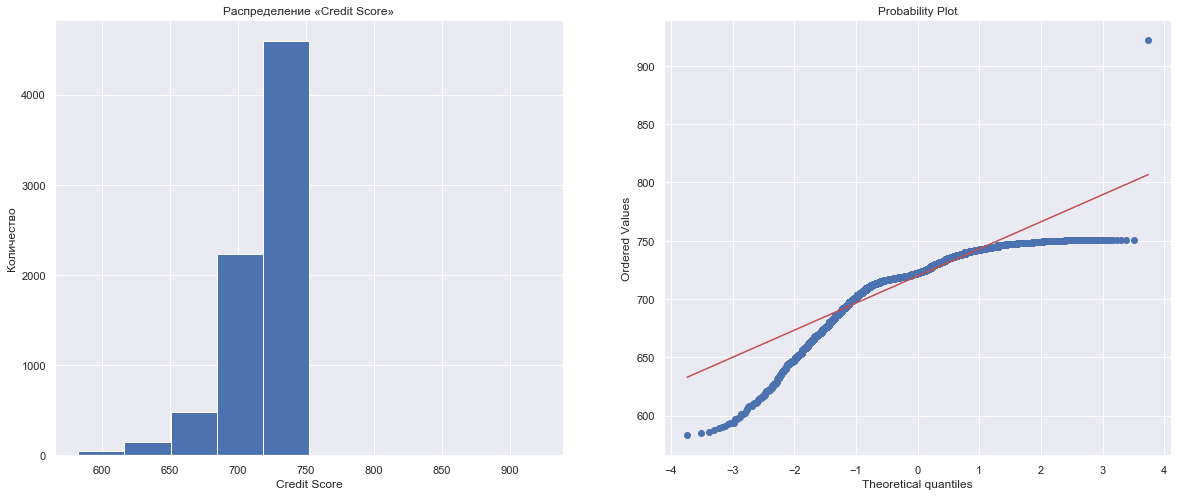

По показателю «Credit Score» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


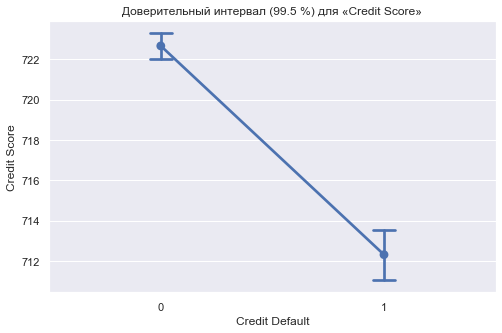

In [46]:
for cat_colname in df_train[BASE_FEATURE_NAMES].select_dtypes(include=['float64'], exclude=['object']).columns:
        if 'Tax Liens' == cat_colname or 'Number of Credit Problems' == cat_colname or 'Bankruptcies' == cat_colname:
            check_rate(df_train, TARGET_NAME, cat_colname, False)
        else:
            check_rate(df_train, TARGET_NAME, cat_colname)

По итогам анализа

Следующие показатели необходимо нормализовать логарифмированием:
- Maximum Open Credit
- Current Credit Balance

Следующие показатели не влияют на целевую переменную, поэтому от них можем избавиться:  
- Bankruptcies
- Monthly Debt

Слудующие показатели очень хорошо влияют на целевую переменную:  
- Annual Income
- Number of Open Accounts
- Maximum Open Credit
- Months since last delinquent
- Current Loan Amount
- Credit Score

Следующие показатели менее существенно влияют на целевую переменную:  
- Tax Liens
- Years of Credit History
- Number of Credit Problems
- Current Credit Balance

##### Анализ признакового пространства

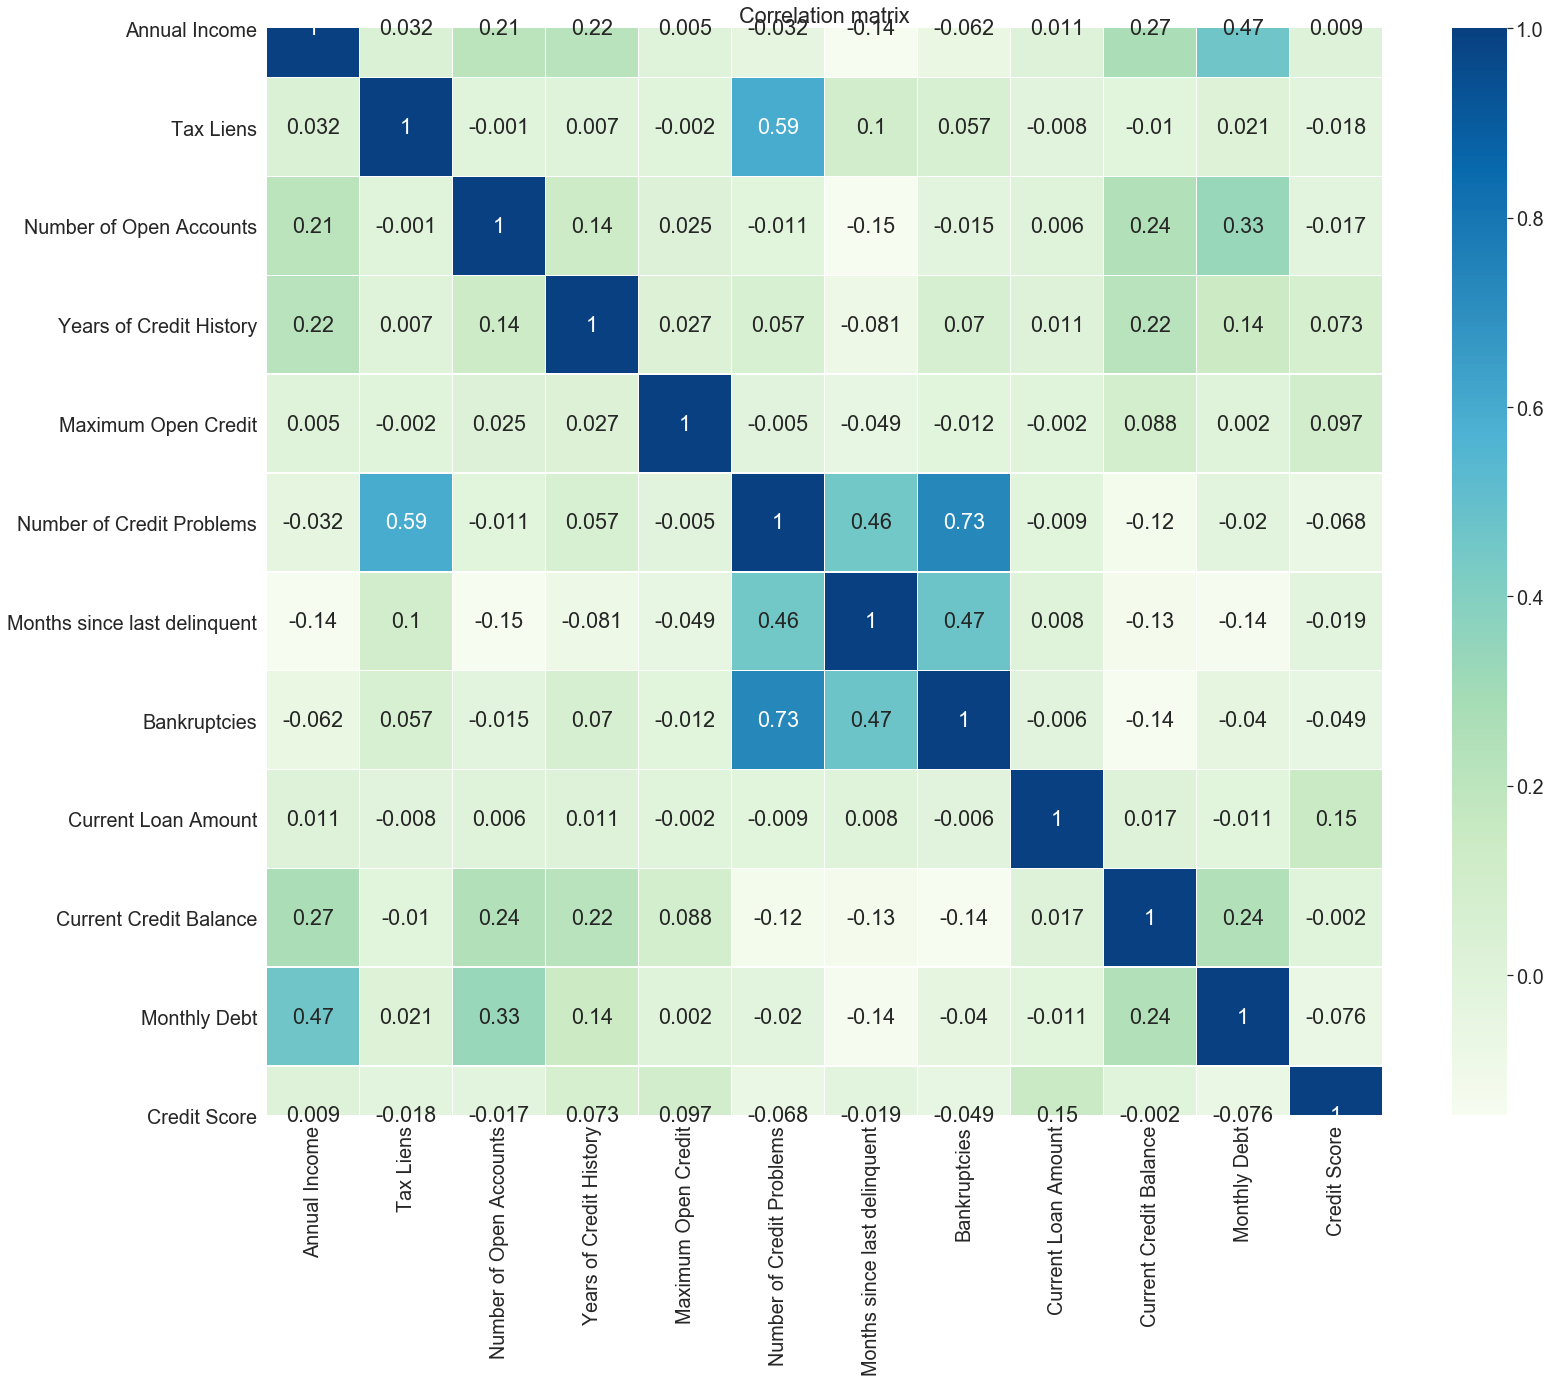

In [47]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.8)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### 5. Отбор признаков

#### Нормализация данных

In [48]:
NUM_FEATURE_NAMES = ['Annual Income',
                     'Tax Liens',
                     'Number of Open Accounts',
                     'Years of Credit History',
                     'Maximum Open Credit',
                     'Number of Credit Problems',
                     'Months since last delinquent',
                     'Current Loan Amount',
                     'Current Credit Balance',
                     'Credit Score',
                     'Is_Years_in_current_job']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + [
                                                'Is_Term',
                                                'Is_Home_Ownership',
                                                'Is_Purpose_business loan',
                                                'Is_Purpose_other',
                                                'Is_Purpose_small business'
                                                ]

In [50]:
scaler = StandardScaler().fit(df_norm[NUM_FEATURE_NAMES])

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

In [51]:
df_test_norm = df_test.copy()
df_test_norm[NUM_FEATURE_NAMES] = scaler.transform(df_test_norm[NUM_FEATURE_NAMES])

df_test = df_test_norm.copy()

#### Разбиение на train и test

In [52]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### 6. Балансировка целевой переменной

In [53]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [54]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### 7. Подбор моделей, получение Baseline

**Логистическая регрессия**

In [55]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.76      0.71      3771
           1       0.62      0.50      0.56      2958

    accuracy                           0.65      6729
   macro avg       0.64      0.63      0.63      6729
weighted avg       0.64      0.65      0.64      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.74      0.77      1616
           1       0.43      0.50      0.46       634

    accuracy                           0.67      2250
   macro avg       0.61      0.62      0.61      2250
weighted avg       0.69      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1199  417
1                319  315


**k ближайших соседей**

In [56]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.80      0.79      3771
           1       0.73      0.70      0.72      2958

    accuracy                           0.76      6729
   macro avg       0.75      0.75      0.75      6729
weighted avg       0.76      0.76      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1616
           1       0.37      0.42      0.39       634

    accuracy                           0.63      2250
   macro avg       0.56      0.57      0.56      2250
weighted avg       0.65      0.63      0.64      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1158  458
1                368  266


**Бустинговые алгоритмы**

*XGBoost*

In [57]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3771
           1       0.97      0.98      0.98      2958

    accuracy                           0.98      6729
   macro avg       0.98      0.98      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1616
           1       0.41      0.39      0.40       634

    accuracy                           0.67      2250
   macro avg       0.59      0.59      0.59      2250
weighted avg       0.67      0.67      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1259  357
1                386  248


*LightGBM*

In [58]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3771
           1       0.90      0.90      0.90      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1616
           1       0.41      0.43      0.42       634

    accuracy                           0.66      2250
   macro avg       0.59      0.59      0.59      2250
weighted avg       0.67      0.66      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1216  400
1                360  274


*CatBoost*

In [59]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3771
           1       0.88      0.87      0.88      2958

    accuracy                           0.89      6729
   macro avg       0.89      0.89      0.89      6729
weighted avg       0.89      0.89      0.89      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1616
           1       0.44      0.46      0.45       634

    accuracy                           0.68      2250
   macro avg       0.61      0.62      0.61      2250
weighted avg       0.69      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1247  369
1                342  292


### 8. Выбор наилучшей модели, настройка гиперпараметров

In [60]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

**Подбор гиперпараметров**

In [61]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500], 'max_depth':[3, 5, 7]}

In [62]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [63]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 1min 32s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000014D4CEAF448>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [64]:
rs.best_params_

{'n_estimators': 50, 'max_depth': 5}

In [65]:
rs.best_score_

0.5099029295012407

**Обучение и оценка финальной модели**

In [66]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      3771
           1       0.71      0.68      0.70      2958

    accuracy                           0.74      6729
   macro avg       0.74      0.73      0.73      6729
weighted avg       0.74      0.74      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1616
           1       0.44      0.55      0.49       634

    accuracy                           0.68      2250
   macro avg       0.62      0.64      0.63      2250
weighted avg       0.70      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1178  438
1                288  346
Wall time: 4.25 s


### 9. Проверка качества, борьба с переобучением

In [67]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, l2_leaf_reg=10,silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3771
           1       0.75      0.73      0.74      2958

    accuracy                           0.78      6729
   macro avg       0.77      0.77      0.77      6729
weighted avg       0.78      0.78      0.78      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1616
           1       0.44      0.53      0.48       634

    accuracy                           0.68      2250
   macro avg       0.62      0.63      0.62      2250
weighted avg       0.70      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1185  431
1                299  335


**Подбор оптимального размера выборки, кривая обучения**

In [68]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

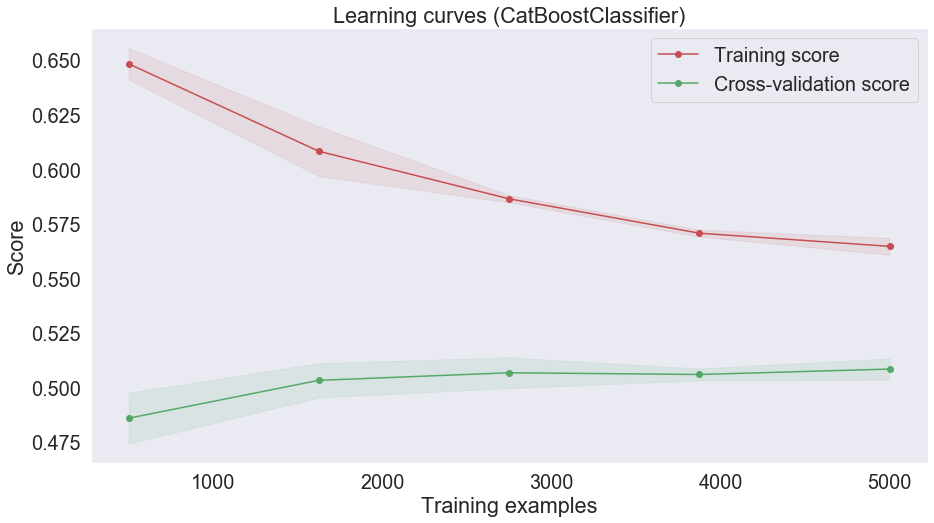

In [69]:
show_learning_curve_plot(final_model, X, y)

**Выбор порога вероятности для определения класса**

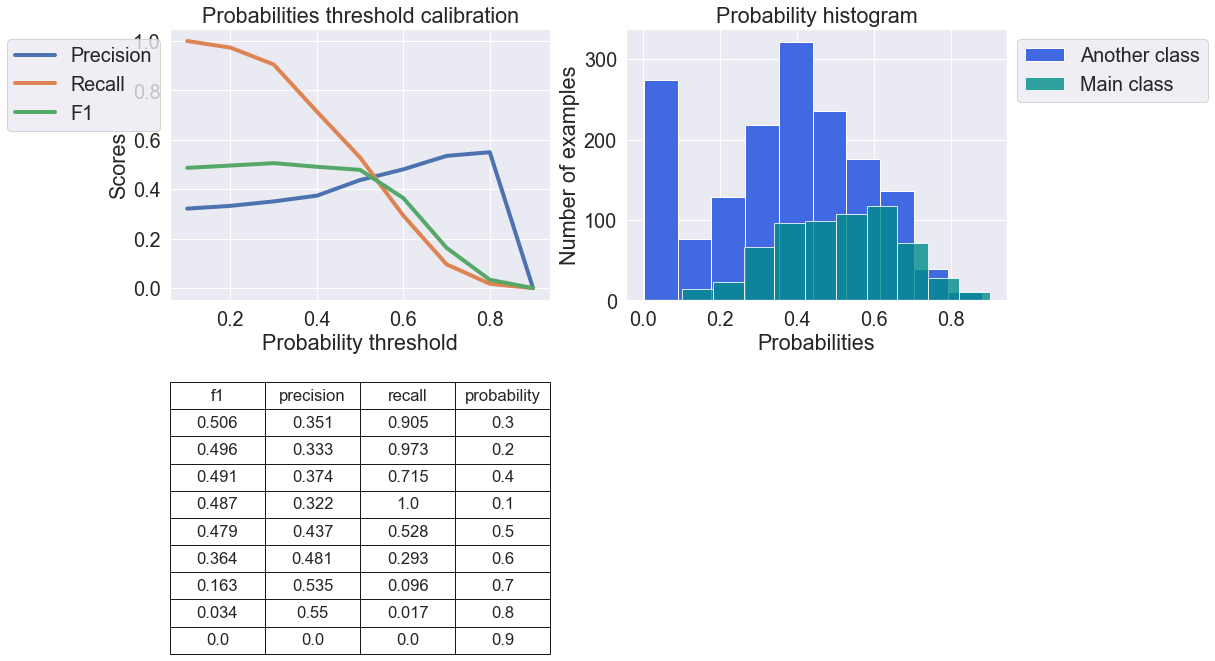

In [70]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

**Важность признаков**

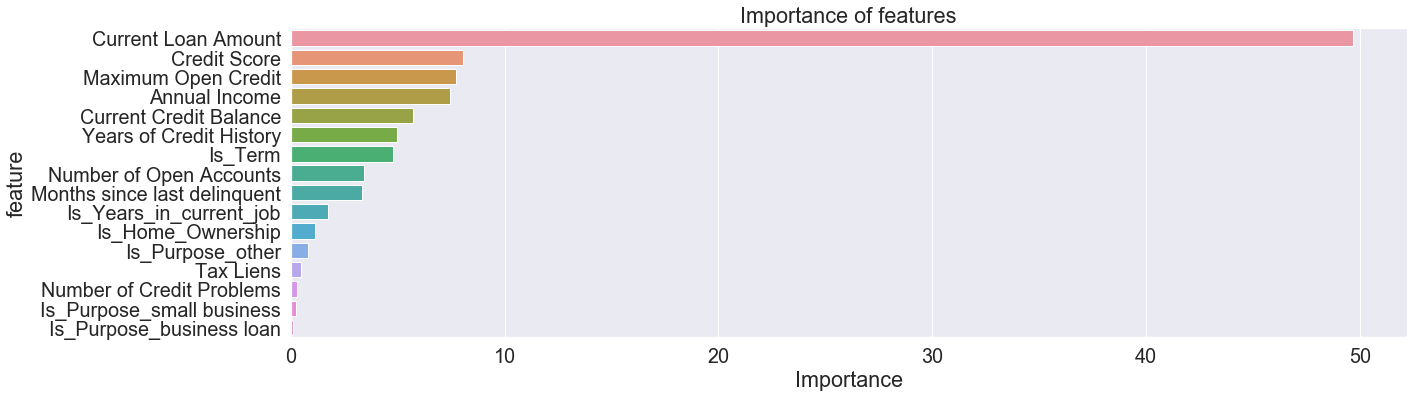

In [71]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=10)

In [72]:
important_features_top

['Current Loan Amount',
 'Credit Score',
 'Maximum Open Credit',
 'Annual Income',
 'Current Credit Balance',
 'Years of Credit History',
 'Is_Term',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Is_Years_in_current_job']

**Финальная модель**

In [73]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])

y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])
y_test_pred = y_test_pred_probs[:,1] > 0.538

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      3771
           1       0.76      0.73      0.74      2958

    accuracy                           0.78      6729
   macro avg       0.78      0.77      0.77      6729
weighted avg       0.78      0.78      0.78      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1616
           1       0.46      0.44      0.45       634

    accuracy                           0.70      2250
   macro avg       0.62      0.62      0.62      2250
weighted avg       0.69      0.70      0.69      2250

CONFUSION MATRIX

col_0           False  True 
Credit Default              
0                1285    331
1                 355    279


### 10. Интерпретация результатов

In [74]:
y_result = final_model.predict(df_test[important_features_top])

In [75]:
result = pd.DataFrame({'ID': df_test['ID'], 'Credit Default': y_result})

In [76]:
result['Credit Default'].value_counts()

0    1709
1     791
Name: Credit Default, dtype: int64

In [77]:
result.to_csv(RESULT_FILE, index=False, encoding='utf-8')